# Programming assignment #6

- Name: Kecheng Xiao
- ID: 1008709140


## 0. Import Libraries

In [96]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

## 1. Read and Split Data

In [97]:
# get monthly data
tb1_m = pd.read_excel('mth_rolling_features.xlsx', sheet_name='Sheet1')
tb2_m = pd.read_excel('mth_day_counts.xlsx', sheet_name='Sheet1')
tb3_m = pd.read_excel('days_since_last_txn.xlsx', sheet_name='Sheet1')

In [98]:
# get response
tb_r = pd.read_csv('Retail_Data_Response.csv')

In [99]:
# get monthly data
tb_r.rename(columns={'customer_id': 'CLNT_NO'}, inplace=True) # rename to regularize
monthly_features_outputs = pd.merge(pd.merge(pd.merge(tb1_m, tb2_m, on=['CLNT_NO', 'ME_DT']), tb3_m, on=['CLNT_NO', 'ME_DT']), tb_r, on='CLNT_NO')
monthly_features_outputs.fillna(0, inplace=True) # fill redundant NaN due to window size
monthly_features_outputs.drop(columns=['Unnamed: 0', 'Unnamed: 0_x', 'Unnamed: 0_y'], inplace=True) # drop old index
monthly_features_outputs

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_amt_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,...,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn,response
0,CS1112,2011-05-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0,0,0,0,0,0,0,-100,0
1,CS1112,2011-06-30,56,1,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0,0,0,0,0,0,1,15,0
2,CS1112,2011-07-31,0,0,56.0,18.666667,56.0,1.0,0.333333,1.0,...,0.0,0,0,0,0,0,0,0,46,0
3,CS1112,2011-08-31,96,1,152.0,50.666667,96.0,2.0,0.666667,1.0,...,0.0,1,0,0,0,0,0,0,12,0
4,CS1112,2011-09-30,0,0,96.0,32.000000,96.0,1.0,0.333333,1.0,...,0.0,0,0,0,0,0,0,0,42,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323543,CS9000,2014-11-30,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.0,0,0,0,0,0,0,0,98,0
323544,CS9000,2014-12-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.0,0,0,0,0,0,0,0,129,0
323545,CS9000,2015-01-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.0,0,0,0,0,0,0,0,160,0
323546,CS9000,2015-02-28,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.0,0,0,0,0,0,0,0,188,0


In [100]:
# Monthly X and y
X_monthly = monthly_features_outputs.drop(columns=['CLNT_NO', 'ME_DT', 'response']).astype(float)
y_monthly = monthly_features_outputs['response']
# split data
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly =\
    train_test_split(X_monthly, y_monthly, test_size=1/10, random_state=1147)
# standardize monthly data
scaler = StandardScaler()
X_train_monthly_scaled = scaler.fit_transform(X_train_monthly)
X_test_monthly_scaled = scaler.transform(X_test_monthly)

In [101]:
# check split result
print(X_test_monthly_scaled.shape)
print(X_train_monthly_scaled.shape)

(32355, 28)
(291193, 28)


## 2. Create Function to Run with Random N Samples

In [102]:
# use the best max_depth dt model and return test AUC
def optimized_decision_tree(sample_size=50, seed=0):
    # shuffle X for training
    np.random.seed(seed)
    rand = list(np.random.permutation(X_train_monthly_scaled.shape[0])[:sample_size])

    # use monthly dataset
    X_train, y_train = X_train_monthly.iloc[rand], y_train_monthly.iloc[rand]
    X_test, y_test = X_test_monthly, y_test_monthly
    # use optimization depth for tree models
    model_t = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=1147)

    # fit the model
    model_t.fit(X_train, y_train)
    # scores for test set
    scores_test_t = model_t.predict_proba(X_test)[:, 1]

    # Testing ROC Calc
    fpr_test_t, tpr_test_t, _ = roc_curve(y_test, scores_test_t)
    # Testing AUC Calc
    auc_test_t = auc(fpr_test_t, tpr_test_t)

    # return best model
    return auc_test_t

In [103]:
# set function to generate and show
def sampled_test_auc(sample_size = 50, itr = 10):
    test_auc = []
    for i in range(itr):
        test_auc.append([i+1,optimized_decision_tree(sample_size=sample_size ,seed=i)])

    # print table
    s_test_auc = pd.DataFrame(test_auc, columns=['sample #', 'Test AUC'])
    return s_test_auc

def mean_std(data):
    mean = float(np.mean(data))
    std = float(np.std(data))
    print('Mean Test AUC: %.4f | SD Test AUC: %.4f' % (mean, std))
    return mean, std

def show(size=50, print_tb=True):
    s = sampled_test_auc(size)
    if print_tb:
        print('   N = %d samples' % size)
        print(s.to_string(index=False))
    mean, std = mean_std(s['Test AUC'])
    return size, mean, std

In [104]:
# run for size 50
show(50)

   N = 50 samples
 sample #  Test AUC
        1  0.510480
        2  0.508930
        3  0.530874
        4  0.519574
        5  0.489810
        6  0.527492
        7  0.509490
        8  0.513056
        9  0.502588
       10  0.535099
Mean Test AUC: 0.5147 | SD Test AUC: 0.0131


(50, 0.514739374190607, 0.013085235191898302)

## 3. Repeat Above with More Sample Size

In [105]:
# repeat for sample size N
size_ls = [50, 100, 500, 1000, 1500, 2000, 3000,
           4000, 5000, 7500, 10000, 20000, 25000,
           50000, 80000, 100000, 200000, 250000]
test_auc_ls = []
for v in size_ls:
    s_size, s_mean, s_std = show(v, print_tb=False)
    test_auc_ls.append([s_size, s_mean, s_std])

Mean Test AUC: 0.5147 | SD Test AUC: 0.0131
Mean Test AUC: 0.5166 | SD Test AUC: 0.0251
Mean Test AUC: 0.5281 | SD Test AUC: 0.0176
Mean Test AUC: 0.5384 | SD Test AUC: 0.0211
Mean Test AUC: 0.5567 | SD Test AUC: 0.0211
Mean Test AUC: 0.5684 | SD Test AUC: 0.0130
Mean Test AUC: 0.5812 | SD Test AUC: 0.0098
Mean Test AUC: 0.5886 | SD Test AUC: 0.0085
Mean Test AUC: 0.5982 | SD Test AUC: 0.0103
Mean Test AUC: 0.6041 | SD Test AUC: 0.0063
Mean Test AUC: 0.6107 | SD Test AUC: 0.0083
Mean Test AUC: 0.6232 | SD Test AUC: 0.0064
Mean Test AUC: 0.6275 | SD Test AUC: 0.0046
Mean Test AUC: 0.6364 | SD Test AUC: 0.0048
Mean Test AUC: 0.6394 | SD Test AUC: 0.0021
Mean Test AUC: 0.6407 | SD Test AUC: 0.0023
Mean Test AUC: 0.6425 | SD Test AUC: 0.0019
Mean Test AUC: 0.6432 | SD Test AUC: 0.0019


## 4. Show with Table

In [108]:
df_test_auc = pd.DataFrame(test_auc_ls, columns=['N', 'Mean Test AUC', 'Std Test AUC'])
df_test_auc

,N,Mean Test AUC,Std Test AUC
0,50,0.514739,0.013085
1,100,0.516582,0.025128
2,500,0.528074,0.017561
3,1000,0.538414,0.021071
4,1500,0.556728,0.021064
5,2000,0.568428,0.012963
6,3000,0.581221,0.009827
7,4000,0.588575,0.008523
8,5000,0.598192,0.010333
9,7500,0.604140,0.006297


## 5. Plot with `errorbar()`

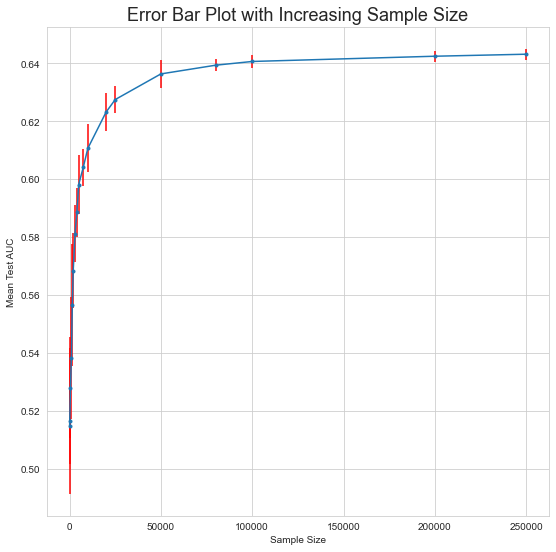

In [109]:
plt.figure(figsize=(9, 9))
plt.errorbar(df_test_auc['N'], df_test_auc['Mean Test AUC'], df_test_auc['Std Test AUC'],
             marker = '.', ecolor = 'red')
plt.xlabel('Sample Size')
plt.ylabel('Mean Test AUC')
plt.title('Error Bar Plot with Increasing Sample Size', fontsize=18)
plt.show()

#### Comment
In the error-bar plot we can easily with increasing sample size, the AUC value rises and the standard deviation gradually drops.

And when the sample size reach it's elbow point of testing AUC curve (sample size = 50000), the `Mean Test AUC` can describe behaviour well; however, the next sample size have significantly lower `Std Test AUC`(standard deviation of test AUC). Overall, I would choose sample size 80000 as the minimum to show the model behavior adequately.